In [ ]:
###### OBS: NO FINAL, O BERT DA RESULTADOS MUITO ALTOS E NÃO ERA PRA SER ASSIM.

# Projeto de PLN: explorando um corpus de Clarice Lispector e adentrando no mundo dos "embeddings".
Autora: Renata Leite Leandro

## Setup
Usaremos os seguintes pacotes neste projeto:

In [1]:
# Importando os pacotes que serão utilizados:
import spacy
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import json
import transformers
from wordcloud import WordCloud

E, para uma boa visualização dos gráficos que serão plotados, usamos os seguintes comandos:

In [2]:
# Adiciona linhas no background dos gráficos, facilitando a visualização
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set(style="whitegrid", rc=custom_params)

## Sobre o dataset

Utilizaremos um corpus com alguns livros da Clarice Lispector (A Hora da estrela, Crônicas e Todos os Contos). Este corpus encontra-se pré-processado, isto é, dividido em uma lista de sentenças, sendo que cada sentença é dividida em uma lista de palavras; ademais, a pontuação já foi removida, e o texto não apresenta letras maiúsculas. A única questão que deve ser ressaltada é que, infelizmente, palavras com caracteres especiais encontram-se corrompidas, e, por isso, deverão ser excluídas.

O arquivo está no formato ‘json’, então nós o leremos com a biblioteca json:

In [3]:
# Abrindo e lendo o dataset:
data = open('corpus_tokenizado.json')
corpus = json.load(data)

Precisamos também separar esse corpus já pré-processado em palavras. Observe:

In [4]:
# Separando o corpus em uma grande lista de palavras:
from nltk.tokenize import word_tokenize
wordlist0 = word_tokenize(corpus)

# Removendo todos os caracteres não-alfabéticos e pontuações:
wordlist = []
for word in wordlist0:
    if word.isalpha():
        wordlist += [word]

Como já dito, as palavras com caracteres especiais do dataset estavam corrompidas. Optamos, portanto, por descartá-las antes mesmo de inserí-las na contagem de frequencia, já que foi verificado que as palavras corrompidas mais frequentes eram, em sua grande maioria, stopwords.

Agora, podemos prosseguir!

# Parte I - Exploração do corpus

Nessa etapa, buscaremos analisar o corpus de diferentes maneiras e tirar conclusões com base em análises quantitativas. Com tal objetivo em mente, podemos começar verificando quais palavras, stemmas (ou seja, raízes de palavras) e classes gramaticais aparecem com maior frequência.

## Frequência de palavras

Primeiramente, vamos criar uma lista de stopwords para podermos ignorar palavras que possuem pouco significado, como preposições e artigos. Observe:

In [5]:
# Acessando a lista de stopwords do português:
stopwords = nltk.corpus.stopwords.words('portuguese')

Iremos, agora, contar a frequência de cada palavra com 'FreqDist' e selecionar aquelas mais frequentes com um loop que desprezará as stopwords. Em seguida, separaremos as palavras e frequências para podermos construir um gráfico de barras.

In [6]:
# Contando a frequência de palavras com nltk FreqDist:
from nltk.probability import FreqDist
freq_palavras = FreqDist(wordlist)

# Selecionando as mais frequentes (ignorando stopwords):
n = 0   # Contador que controla o loop e marca em qual palavra estamos dentre as mais frequentes.
lista_frequentes = []
while n != 71:
    if freq_palavras.most_common(71)[n][0] not in stopwords:
        lista_frequentes.append(freq_palavras.most_common(71)[n])
    n = n + 1
print('As palavras mais frequentes do corpus são:', lista_frequentes)

As palavras mais frequentes do corpus são: [('porque', 972), ('vida', 897), ('mim', 749), ('homem', 722), ('disse', 705), ('bem', 704), ('tudo', 702), ('ter', 691), ('coisa', 669), ('pois', 668), ('dia', 643), ('nada', 610), ('ainda', 604), ('vez', 593), ('sei', 586), ('mundo', 584), ('pouco', 572), ('nunca', 570), ('assim', 556), ('casa', 533)]


In [7]:
# Separando a lista_frequentes em 'lista_plv' e 'lista_freq':
lista_plv = []
lista_freq = []
for item in lista_frequentes:
    lista_plv = lista_plv + [item[0]]
    lista_freq = lista_freq + [item[1]]

Finalmente, obtemos o seguinte resultado:

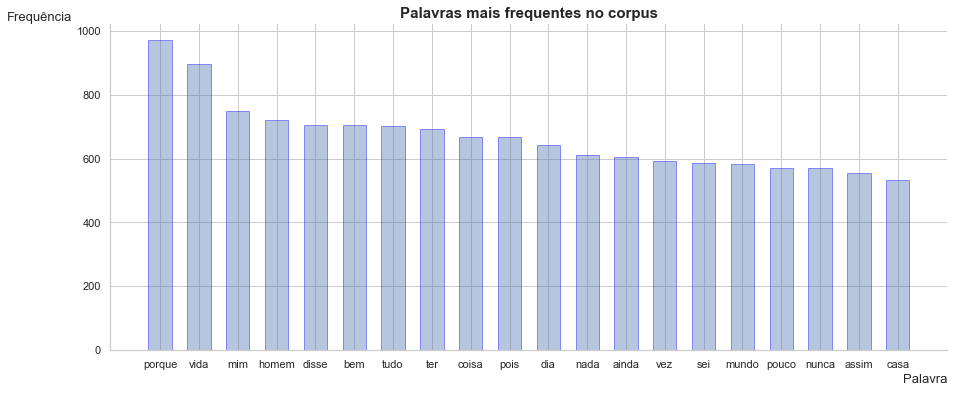

In [8]:
# Plotando o gráfico:
plt.figure(figsize = (15, 6))
plt.title('Palavras mais frequentes no corpus', fontsize=15, weight='bold')
plt.xlabel('Palavra', fontsize=13, loc='right')
plt.ylabel('Frequência', rotation=0, fontsize=13, loc='top')
plt.bar(lista_plv, lista_freq, width=0.6, edgecolor='blue', alpha=0.4)
plt.show()

À primeira vista, as 20 palavras mais frequentes do dataset pouco parecem revelar sobre as obras por serem bastante cotidianas; no entanto, é importante relembrar que a própria cotidianidade do conteúdo destaca-se como uma característica da escrita de Clarice, e, embora essas palavras sejam "comuns" e "naturalmente mais frequentes", o gráfico provavelmente seria consideravelmente diferente se os textos analisados fossem discursos jornalísticos ou artigos científicos. Além disso, é possível argumentar que substantivos como "vida" e "mundo" sejam pequenas pistas da natureza reflexiva das obras da escritora, e ainda que a alta presença do léxico "coisa" seja capaz de demonstrar o movimento de rebaixamento do conteúdo poético, frequente em sua escrita.

## Frequência de raízes de palavras

Para as raízes, o processo é praticamente o mesmo, só que com um pequeno trabalho a mais: precisamos, inicialmente, "cortar" os afixos das palavras, reduzindo-as às suas bases. Para isso, usaremos a função Stemming:

In [9]:
# Criando uma função que stemmiza uma dada lista de palavras.
from nltk.stem import RSLPStemmer    # Stemmer para português.
def Stemming(wordlist):
    """Entrada: uma lista de palavras que passará pelo processo de stemmatização.
       Saída: as raízes da lista de palavras dada.                            """
    stemmer = RSLPStemmer()
    stemlist = []
    for word in wordlist:
        stemlist.append(stemmer.stem(word.lower()))
    return stemlist

stemlist = Stemming(wordlist)    # Verificando as raízes do corpus.
stemstopwords = Stemming(stopwords)    # Transformando as stopwords em raízes equivalentes para comparação.

Pronto! Agora podemos prosseguir de maneira semelhante ao primeiro caso. 

In [10]:
# Contando a frequência de palavras com nltk FreqDist:
freq_raizes = FreqDist(stemlist)

# Selecionando as mais frequentes (ignorando stopwords):
n = 0   # Contador que controla o loop e marca em qual palavra estamos dentre as mais frequentes.
lista_frequentes2 = []
while n != 64:
    if freq_raizes.most_common(64)[n][0] not in stemstopwords:
        lista_frequentes2.append(freq_raizes.most_common(64)[n])
    n = n + 1
print('As raízes mais frequentes do corpus são:', lista_frequentes2)

As raízes mais frequentes do corpus são: [('olh', 1264), ('outr', 1210), ('tod', 1170), ('sent', 1062), ('sab', 1045), ('vez', 1038), ('cois', 1020), ('porqu', 972), ('pod', 964), ('faz', 940), ('vid', 936), ('pens', 923), ('diss', 904), ('diz', 890), ('hom', 874), ('dia', 838), ('quer', 800), ('cas', 793), ('am', 780), ('escrev', 754)]


In [11]:
# Separando a lista_frequentes2 em 'lista_plv' e 'lista_freq':
lista_plv2 = []
lista_freq2 = []
for item in lista_frequentes2:
    lista_plv2 = lista_plv2 + [item[0]]
    lista_freq2 = lista_freq2 + [item[1]]

E, finalmente:

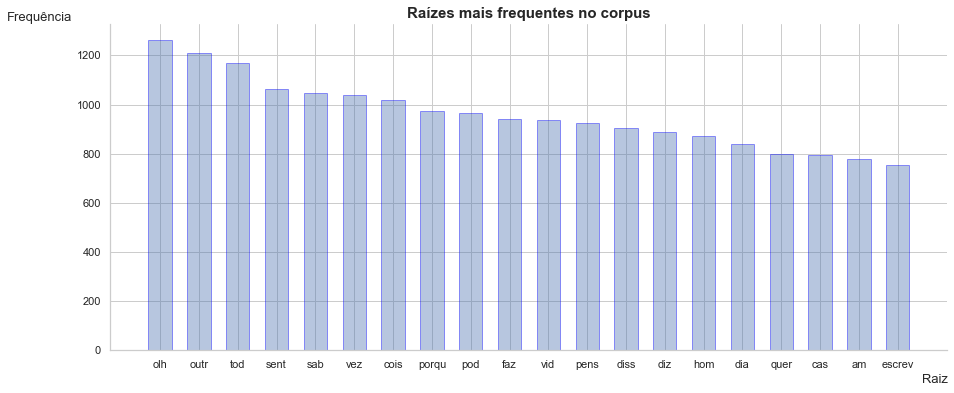

In [12]:
# Plotando o gráfico:
plt.figure(figsize = (15, 6))
plt.title('Raízes mais frequentes no corpus', fontsize=15, weight='bold')
plt.xlabel('Raiz', fontsize=13, loc='right')
plt.ylabel('Frequência', rotation=0, fontsize=13, loc='top')
plt.bar(lista_plv2, lista_freq2, width=0.6, edgecolor='blue', alpha=0.4)
plt.show()

Neste gráfico, embora o foco da análise seja outra, a situação encontrada não é muito diferente da anterior: novamente, encontramos palavras "comuns" que demonstram o conteúdo cotidiano dos textos, além de algumas pistas da natureza reflexiva das obras e de uma escrita que é, simultaneamente, poética e corriqueira.

## Frequência de classes gramaticais

Já para as classes gramaticais, utilizaremos o spaCy, que, carregado em português, será capaz de realizar a "tagging" de nosso corpus, predizendo as classes gramaticais de cada palavra da 'wordlist'.

In [13]:
# Carregando o Spacy para português.
nlp = spacy.load("pt_core_news_sm")

Porém, para que nosso corpus possa ser lido sem nenhum problema, precisamos transformar a 'wordlist' em uma grande e única string de várias palavras. Veja abaixo:

In [14]:
# Criando a variável 'fulltext' que converte a list 'wordlist' em string, ação necessária para rodar a linha 'doc = nlp(fulltext)':
fulltext = ' '.join(wordlist)

nlp.max_length = len(fulltext) + 100    # Aumenta o limite para não dar erro.
doc = nlp(fulltext)

Finalmente, podemos criar a lista das classes gramaticais através do uso de 'token.tag_', além de um dicionário que relaciona as palavras com suas respectivas classes preditas.

In [15]:
# Criando uma lista das classes gramaticais presentes e um dicionário que relaciona as palavras da wordlist com sua classe gramatical predita.
classlist = []
classdict = {}
for token in doc:
    classlist.append(token.tag_)
    classdict.update({token.text : token.tag_})

E, novamente, a resolução assemelha-se as outras:

In [16]:
# Contando a frequência de palavras com nltk FreqDist:
freq_class = FreqDist(classlist)

# Selecionando as mais frequentes:
lista_frequentes3 = freq_class.most_common(10)
print('As classes gramaticais mais frequentes do corpus são:', lista_frequentes3)

As classes gramaticais mais frequentes do corpus são: [('NOUN', 66570), ('VERB', 57494), ('ADP', 46403), ('DET', 38677), ('PRON', 38230), ('ADV', 19541), ('SCONJ', 18758), ('ADJ', 18561), ('CCONJ', 15937), ('AUX', 10382)]


In [17]:
# Separando a lista_frequentes3 em 'lista_plv' e 'lista_freq':
lista_plv3 = []
lista_freq3 = []
for item in lista_frequentes3:
    lista_plv3 = lista_plv3 + [item[0]]
    lista_freq3 = lista_freq3 + [item[1]]

E, por fim:

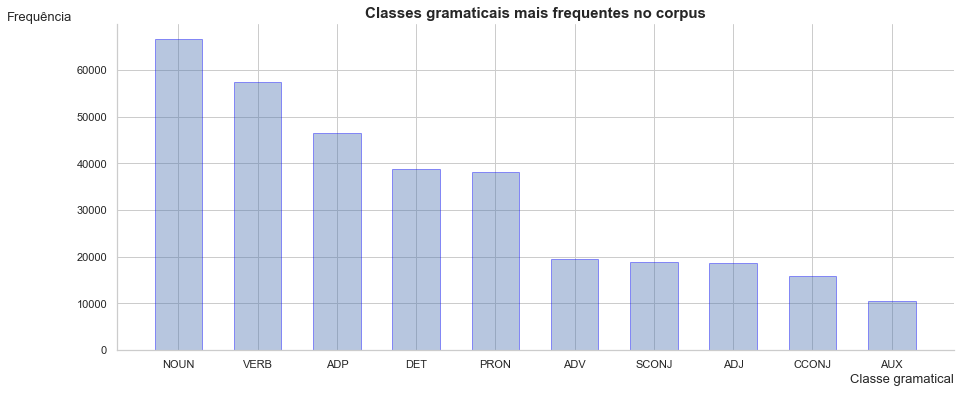

*Legenda (em ordem): substantivo; verbo; adposição; determinante; pronome; advérbio; conjunção subordinada; adjetivo; conjunção coordenada; auxiliar.*


In [18]:
# Plotando o gráfico:
plt.figure(figsize = (15, 6))
plt.title('Classes gramaticais mais frequentes no corpus', fontsize=15, weight='bold')
plt.xlabel('Classe gramatical', fontsize=13, loc='right')
plt.ylabel('Frequência', rotation=0, fontsize=13, loc='top')
plt.bar(lista_plv3, lista_freq3, width=0.6, edgecolor='blue', alpha=0.4)
plt.show()
print('*Legenda (em ordem): substantivo; verbo; adposição; determinante; pronome; advérbio; conjunção subordinada; adjetivo; conjunção coordenada; auxiliar.*')

Já em relação à frequência de classes gramaticais, temos que substantivos (≅ 7000), verbos(≅ 6000) e pronomes (≅ 4000) são, conforme o esperado, as mais comuns. Um ponto importante, porém, é que advérbios e adjetivos também são bastante presentes, com frequências próximas a 2000 ocorrências, indicando o caráter literário das obras de Clarice, pouco "enxuto".

## NER, ou Reconhecimento de Entidade Mencionada

Por último, podemos identificar as entidades nomeadas presentes no conjunto de dados, que podem ser, principalmente, pessoas, datas, números, locais ou organizações. Veja:

In [216]:
# Armazenando as entidades nomeadas encontradas no texto (com repetições):
entlist = []
for ent in doc.ents:
    entlist.append(str(ent))  
    
# Contando a frequência de palavras com nltk FreqDist:
freq_ent = FreqDist(entlist)

# Selecionando as mais frequentes:
lista_frequentes4 = freq_ent.most_common(50)
print('As entidades mencionadas mais frequentes do corpus são:', lista_frequentes4)

As entidades mencionadas mais frequentes do corpus são: [('brasil', 173), ('clarice', 121), ('daniel', 80), ('maria', 57), ('clarice lispector', 55), ('catarina', 35), ('eduardo', 33), ('rio de janeiro', 29), ('jaime', 29), ('jesus', 25), ('estados unidos', 25), ('lua', 24), ('cristo', 22), ('ana', 22), ('londres', 22), ('paris', 21), ('vim', 20), ('xavier', 20), ('pedi', 19), ('recife', 16), ('alice', 16), ('jimmy', 15), ('berna', 14), ('rosas', 14), ('linda', 13), ('washington', 13), ('terra', 13), ('maria das dores', 13), ('paulo', 12), ('espanha', 12), ('leopoldo', 11), ('artur', 11), ('zilda', 11), ('hein', 10), ('europa', 10), ('inglaterra', 10), ('cristiano', 10), ('salvador', 9), ('francisco', 9), ('bob', 9), ('sra xavier', 9), ('roma', 8), ('minas gerais', 8), ('belo horizonte', 8), ('roberto carlos', 8), ('dona maria rita', 8), ('henrique', 7), ('pedro', 7), ('academia brasileira de letras', 7), ('bahia', 7)]


In [217]:
# Transformando a lista_frequentes4 em um dicionário para a posterior criação de um wordcloud:
dict_frequentes = {}
for lista in lista_frequentes4:
    dict_frequentes.update({lista[0] : lista[1]})

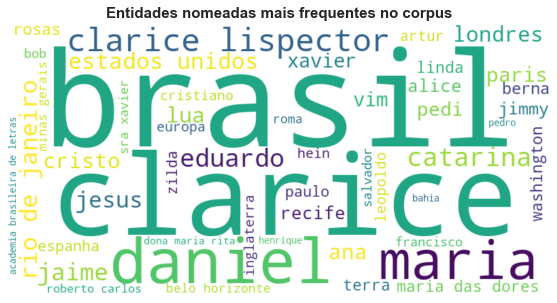

In [222]:
# Plotando o gráfico:
nuvem_de_palavras = WordCloud(width=800, height=400, background_color='white').fit_words(dict_frequentes)

plt.figure(figsize = (10, 5))
plt.imshow(nuvem_de_palavras, interpolation='bilinear')
plt.title('Entidades nomeadas mais frequentes no corpus', fontsize=15, weight='bold')
plt.axis('off')    # Desativar eixos
plt.show()

Além de simplesmente encontrar as entidades nomeadas mais comuns, podemos dividir tipos de entidades diferentes, o que pode ser útil quando o interesse é específico. Para exemplificar, vamos ver quais são todos os locais presentes no corpus:

In [56]:
# Associando cada entidade à sua categoria de rótulo 
entdict = {}
for ent in doc.ents:
    entdict.update({str(ent) : str(ent.label_)})
    values = entdict.values()

# Filtrando apenas as entidades que se referem a locais (LOC):    
n = 0
locais = []
for value in values:
    if value == 'LOC':
        locais.append(list(entdict.keys())[n])
    n = n + 1
print(locais)

['recife pressentia', 'rio de janeiro', 'paris', 'olimpo', 'universidade do rio de janeiro', 'alagoas', 'redonda do amado', 'alegre', 'rua tenho', 'guatemala', 'rua do acre', 'acre', 'brasil', 'mentia', 's miguel', 'mercado jesus', 'salvador', 'ventania', 'espanha', 'venezuela', 'europa', 'estados unidos', 'santa casa', 'montenegro', 'sodoma', 'berna', 'rua formosa', 'recife', 'rio vi leopoldo', 'sorbonne', 'goiabinha', 'pernambuco', 'rio martim', 'washington', 'nova york', 'aparecida', 'casa de dona pupu', 'usaria', 'inglaterra', 'farei', 'seara', 'rio grande do sul santa maria', 'porto alegre', 'santa maria', 'aproveitarei', 'hong kong', 'lua', 'jaci', 'parque nacional do xingu', 'rio xingu', 'instituto brasileiro de reforma', 'praia', 'marly de oliveira', 'buenos aires', 'terra', 'trepadeira', 'lima peru', 'avancini campinas', 'lima', 'recife virgem maria', 'leme', 'paraguai', 'carnegie hall', 'museu posso', 'menininha', 'terremoto do ventre', 'torre do tombo', 'santa cruz', 'israel

# Parte II - Word2vec

Esta etapa consistirá no uso do word2vec, importante ferramenta para o embedding de palavras. Mas, antes de começarmos, convém responder, afinal, o que é um "embedding de palavras". Esta é uma técnica em que cada vocábulo é transformado em sua versão numérica, que nada mais é do que um vetor (ou matriz 1xN) em que cada dimensão (N) representa um tipo de informação sobre o seu significado em relação ao seu contexto.

## Utilizando o gensim

Para utilizarmos a função word2vec, precisamos, primeiramente, preparar nossos dados, que precisam ser enviados como uma lista de sentenças. Porém, visto que o corpus aqui utilizado não pode ser corretamente separado em sentenças devido ao modo como ele foi fornecido  - isto é, sem pontuações -, iremos simplesmente criar uma lista de listas de palavras separadas arbitrariamente. Para isso, definiremos que cada "sentença" será composta de 17 palavras. Observe:

In [121]:
# Excluindo as stopwords:
words = [word for word in wordlist if word not in stopwords]

# Criando uma lista de sentenças a partir da variável 'words':
n =  10079    # Divisor
inicio = 0
fim = 17
sentences = []
while n != 0:
    sentences += [words[inicio:fim]]
    inicio = fim
    fim += 17
    n -= 1

Agora, para construirmos o nosso modelo, os seguintes parâmetros serão necessários:

- min_count: número mínimo de ocorrências que uma palavra deve ter para ser incluída em nosso modelo. É através desse valor que decidiremos se queremos incluir as "palavras raras" (e, por isso, menos precisas em suas definições) ou não.
- vector_size: a dimensão de cada vetor criado.
- window: um valor N que servirá para determinar qual será o contexto (isto é, as N palavras anteriores e N palavras posteriores) que será considerado ao olharmos para uma determinada palavra.

Veja abaixo como podemos utilizá-los:

In [160]:
from gensim.models import Word2Vec

# Treinando o modelo a partir do nosso cojunto de dados:
model = gensim.models.Word2Vec(sentences, min_count=5, vector_size=80, window=3, sg=0)    # Estamos usando Continuous Bag of Words ou CBOW (sg=0)
model.build_vocab(sentences)
model.train(sentences, total_examples=model.corpus_count, epochs=14)

(1949270, 2398662)

Com o nosso modelo treinado a partir de nosso conjunto de dados (variável 'sentences'), vamos avaliar nossos embeddings a partir dos seguintes critérios:

- similaridade: representa o grau de semelhança existente entre duas palavras (vetores) selecionadas, baseado na medida de similaridade de cossenos. 
- analogia: pode ser entendida por qual palavra está para x (ex: rei), considerando que y (ex: mulher) está para z (ex: homem). Facilmente encontrada a partir da função 'most_similar()'.


Veja abaixo como introduziremos esses critérios:

In [161]:
def similaridade(a, b):
    """ Função que calcula o grau de semelhança entre dois pontos 'a' e
    'b' através do cálculo da similaridade dos cossenos. Quanto maior o
    valor encontrado, maior a semelhança existente.                 """
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

def analogia(y, z, x):
    """ Função que encontra o valor de w, ou palavra que
    está para x, considerando que y está para z.     """
    w = model.wv.most_similar(positive = [x, z], negative = [y])
    return w

Com o objetivo de termos uma ideia da qualidade de nossos embeddings, iniciaremos pela verificação de similaridades com a palavra "homem". Vamos à aplicação:

In [162]:
# Definindo os vetores de cada palavra:
homem = model.wv['homem']
mulher = model.wv['mulher']
pessoa = model.wv['pessoa']
dia = model.wv['dia']
filho = model.wv['filho']

# Chamando a função de similaridades:
homem_x_mulher = similaridade(homem, mulher)
print('A similaridade entre as palavras "homem" e "mulher" é de:', homem_x_mulher)
homem_x_pessoa = similaridade(homem, pessoa)
print('A similaridade entre as palavras "homem" e "pessoa" é de:', homem_x_pessoa)
homem_x_casa = similaridade(homem, dia)
print('A similaridade entre as palavras "homem" e "dia" é de:', homem_x_casa)

# Verificando as palavras mais semelhantes:
similares_homem = model.wv.most_similar('homem')
print('\nAs palavras mais similares a "homem" são:', similares_homem)

A similaridade entre as palavras "homem" e "mulher" é de: 0.8630609
A similaridade entre as palavras "homem" e "pessoa" é de: 0.29222995
A similaridade entre as palavras "homem" e "dia" é de: 0.13234858

As palavras mais similares a "homem" são: [('mulher', 0.8630609512329102), ('quati', 0.7451717853546143), ('menor', 0.7320080995559692), ('filho', 0.7129765748977661), ('cachorro', 0.71186363697052), ('amante', 0.7072482109069824), ('forte', 0.6684004068374634), ('fizera', 0.6678850054740906), ('diante', 0.6677638292312622), ('amava', 0.6674298048019409)]


Vemos que nosso modelo foi capaz de compreender corretamente que o vetor correspondente a "mulher" é mais semelhante a "homem" que o vetor "pessoa", que, por sua vez, apresenta maior similaridade que "dia". Um grande problema, porém, é que a lista de palavras mais similares a "homem" apresenta algumas ocorrências bem inadequadas, como os léxicos "amava", "diante", "fizera", "cachorro" e "quati" (que apresentam até valores maiores que "pessoa", que deveria ser muito mais semelhante). Assim, está claro que, embora o modelo tenha captado corretamente algumas ideias gerais, faltam dados para um melhor treinamento.

In [163]:
# Chamando a função de analogias:
w_filho = analogia(homem, mulher, filho)
print('As palavras que mais provavelmente estão para "filho", sendo que "mulher" está para "homem", são:', w_filho)

As palavras que mais provavelmente estão para "filho", sendo que "mulher" está para "homem", são: [('filho', 0.8425384759902954), ('menino', 0.8163611888885498), ('pai', 0.7685198783874512), ('dona', 0.7661741971969604), ('disse', 0.741052508354187), ('catarina', 0.7231367230415344), ('volta', 0.7178353071212769), ('amiga', 0.7177244424819946), ('marido', 0.7175154685974121), ('filha', 0.7174287438392639)]


No caso das analogias, a situação não é diferente: embora a palavra esperada ("filha") apareça na lista de mais prováveis, ela não está em primeiro lugar, sendo superada por palavras que, novamente, parecem bastante inadequadas, como "disse" e "volta"

Uma possível explicação para essas falhas é que a separação de sentenças dada de maneira arbitrátia, junto à pequena quantidade de palavras disponíveis (que, retiradas as stopwords, fica abaixo de 200.000) possa ter prejudicado a qualidade do modelo. Assim, para melhores resultaos, podemos utilizar modelos pré-treinados!

## Utilizando o repositório de Word Embeddings do NILC

Agora que já criamos nossos próprios embeddings a partir do conjunto de dados fornecido, carregaremos um modelo word2vec do NILC, ou Núcleo Interinstitucional de Linguística Computacional, para, assim, verificarmos algumas diferenças entre os modelos. Usaremos os embeddings gerados via CBOW, com vetores de palavras de 50, 300 e 1000 dimensões.

In [26]:
from gensim.models import KeyedVectors

# Carregando modelos pré-treinados com embeddings de 50, 300 e 1000 dimensões:
model50 = KeyedVectors.load_word2vec_format('cbow_s50.txt')
model300 = KeyedVectors.load_word2vec_format('cbow_s300.txt')
model1000 = KeyedVectors.load_word2vec_format('cbow_s1000.txt')

Para explicitar as diferenças entre esses novos embeddings e os antigos, verificaremos, novamente, com quais palavras o léxico "homem" assemelha-se:

In [164]:
# Verificando as palavras mais semelhantes:
similares_homem_50 = model50.most_similar('homem')
print('\nAs palavras mais similares a "homem" são:', similares_homem_50)
similares_homem_300 = model300.most_similar('homem')
print('\nAs palavras mais similares a "homem" são:', similares_homem_300)
similares_homem_1000 = model1000.most_similar('homem')
print('\nAs palavras mais similares a "homem" são:', similares_homem_1000)


As palavras mais similares a "homem" são: [('monstro', 0.9085395932197571), ('bebé', 0.9072304368019104), ('indivíduo', 0.9050756096839905), ('rapaz', 0.9036116003990173), ('mendigo', 0.9007540345191956), ('rapazola', 0.8992963433265686), ('novelo', 0.8938027620315552), ('pássaro', 0.8897998929023743), ('cão', 0.8882534503936768), ('cãozinho', 0.8869854807853699)]

As palavras mais similares a "homem" são: [('rapaz', 0.7460584044456482), ('garoto', 0.6757828593254089), ('indivíduo', 0.6752874255180359), ('mendigo', 0.6490021347999573), ('ladrão', 0.641203761100769), ('menino', 0.6409417986869812), ('homen', 0.6301384568214417), ('cavalheiro', 0.6294416785240173), ('rapazola', 0.6239607334136963), ('bandido', 0.6235724091529846)]

As palavras mais similares a "homem" são: [('rapaz', 0.6156135201454163), ('indivíduo', 0.5136162042617798), ('garoto', 0.4482877254486084), ('rapazola', 0.4300534725189209), ('menino', 0.42815548181533813), ('pobre-diabo', 0.40529903769493103), ('assaltante'

Os resultados são ótimos! Em especial, os vetores de palavras de 300 e 1000 dimensões conseguiram captar bem o valor semântico dos termos. É possível até mesmo argumentar que a versão de 300 dimensões é superior, inclusive por seu tempo de processamento diminuto.

In [171]:
# Verificando o grau de semelhança:
semelhanca_planta_flor_50 = model50.similarity('planta', 'flor')
print('\nO grau de semelhança entre planta e flor é de:', semelhanca_planta_flor_50)
semelhanca_planta_flor_300 = model300.similarity('planta', 'flor')
print('\nO grau de semelhança entre planta e flor é de:', semelhanca_planta_flor_300)
semelhanca_planta_flor_1000 = model1000.similarity('planta', 'flor')
print('\nO grau de semelhança entre planta e flor é de:', semelhanca_planta_flor_1000)


O grau de semelhança entre planta e flor é de: 0.567941

O grau de semelhança entre planta e flor é de: 0.32192516

O grau de semelhança entre planta e flor é de: 0.19651747


Podemos verificar que, enquanto 50 dimensões parece ser pouco exigente para determinar similaridade entre palavras, 1000 dimensões parece ser "exigente até demais", apresentando uma semelhança baixíssima para palavras não tão distantes.

# Parte III - BERT embeddings

Nesta última etapa, conheceremos melhor o poder do BERT (Bidirectional Encoder Representations from Transformers), algoritmo de Deep Learning para PLN desenvolvido pela Google em 2018. O BERT é baseado na arquitetura transformers, definida pelo mecanismo batizado de self-attention, ou “auto-atenção”. Sendo um modelo bidirecional e pré-treinado em um corpus de texto gigantesco (ou seja, os parâmetros da rede neural só precisam ser refinados), o BERT também é open-source, podendo ser livremente utilizado em diferentes treinamentos de sistemas de processamento de linguagem. E é isso o que faremos aqui.

## BERTimbau

BERTimbau é um modelo BERT pré-treinado para português. Para utilizá-lo, seguimos os seguintes passos:

In [6]:
# Importando as dependências necessárias para o BERTimbau, conforme sua documentação:
from transformers import AutoTokenizer
from transformers import AutoModelForPreTraining
from transformers import AutoModel
import torch


# Chamando o modelo pré-treinado e seu tokenizer correspondente para preparar os dados de entrada no modelo:
pretrained_model = AutoModelForPreTraining.from_pretrained('neuralmind/bert-base-portuguese-cased')
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

Some weights of BertForPreTraining were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Além disso, importaremos a métrica de similaridade de cossenos, que, ao receber dois vetores np.array, gera um valor entre 0 (muito diferentes) e 1 (muito semelhantes), representando a proximidade entre os vetores dados.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

Agora que já inicializamos tudo o que era necessário, podemos criar algumas funções para utilizar o BERT. Seguiremos os seguintes passos:
- Tokenização da sentença;
- Conversão de tokens para tensores;
- Computação dos tensores em embeddings;
- Cálculo da média dos embeddings de uma sentença;
- Obtenção da semelhança entre duas frases pelo cálculo da similaridade dos cossenos.

Para organizar esses passos, criaremos três funções: a primeira tokeniza e converte em tensores, a segunda tira a média dos embeddings da frase e, por último, a terceira apenas realiza o cálculo de similaridade dos cossenos. Observe:

In [213]:
def processamento(primeira_sentença, segunda_sentença):
    """Função que recebe duas sentenças e as devolve prontas (tokenizadas 
    e convertidas em tensores) para serem passadas no BERTimbau.      """
     # Tokenizando as sentenças:
    inputs_formatados = []
    input_id1 = tokenizer.encode(sent1, add_special_tokens=True, padding=True)
    input_id2 = tokenizer.encode(sent2, add_special_tokens=True, padding=True)
    inputs_formatados= input_id1, input_id2
    # Convertendo tokens em tensores Pytorch para que o modelo BERTimbau possa ser alimentado:    
    input_tensores = []
    for input_ids in inputs_formatados:
        input_tensores.append(torch.tensor(input_ids))
    # Preenchendo ("padding") o input menor para que os tamanhos sejam iguais:
    input_tensores = torch.nn.utils.rnn.pad_sequence(input_tensores, batch_first=True) 
    # Separando os subtensores
    subtensores_separados = [input_tensores[i, :] for i in range(input_tensores.shape[0])]
    return subtensores_separados
    
def media_embeddings_sentenca(tensores):
    """Função que tira a média de dois tensores de duas sentenças distintas. """
    media_embeddings = []
    # Colocando o modelo BERTimbau em modo de "avaliação" (feed-forward):
    pretrained_model.eval()
    for tensor in tensores:
        # Calculando os embeddings contextuais (sem computação por gradiente):
        with torch.no_grad():
            outputs = pretrained_model(input_ids = tensor.unsqueeze(0))
            embeddings = outputs[0][0, 1:-1]     # Extrai embeddings para todos os tokens exceto [CLS] e [SEP] (indexes 1:-1).
        # Tirando a média dos embeddings de uma frase: 
        media_embeddings.append(torch.mean(embeddings, dim=0))
    return media_embeddings

def similaridade(medias):
    """Função que calcula a proximidade da media de dois embeddings
    (isto é, duas sentenças) pela similaridade de cossenos.     """
    med1, med2 = medias
    # Calculando a similaridade dos cossenos:
    similarity = torch.cosine_similarity(med1.reshape(1,-1), med2.reshape(1,-1))
    return similarity.item()

Enfim, vamos usá-las!

In [214]:
sent1 = 'Eu gosto da Clarice' 
sent2 = 'Eu gosto de ler Clarice'
sim = similaridade(media_embeddings_sentenca(processamento(sent1, sent2)))
print('A similaridade entre as sentencas', sentencas, 'é de:', sim)

A similaridade entre as sentencas ['Eu gosto da Clarice', 'Eu gosto de ler Clarice'] é de: 0.991168200969696


Considerando que as sentenças são, de fato, muito semelhantes, um alto valor de similaridade era esperado. Mas será que em outros casos o resultado poderia ser diferente?
Pois bem: agora que já temos tudo definido, podemos criar um mapa de calor que informe a semelhança entre diferentes trechos das obras de Clarice Lispector. Veja:

In [231]:
trechos = ["Imaginavazinha, toda supersticiosa, que se por acaso viesse alguma vez a sentir um gosto bem bom de viver",
          "Então defendia-se da morte por intermédio de um viver de menos",
          "Teria ela a sensação de que vivia para nada",
          "Todas as madrugadas ligava o rádio emprestado por uma colega de moradia",
          "Cada gota de minuto que passava",
          "E sobretudo esse canal de rádio aproveitava intervalos entre as tais gotas de minuto para dar anúncios comerciais",
          "Era rádio perfeita pois também entre os pingos do tempo dava curtos ensinamentos",
          "Aí Macabéa disse uma frase que nenhum dos transeuntes entendeu",
          "Nesta hora exata Macabéa sente um fundo enjôo de estômago e quase vomitou"]

# Calculando a similaridade entre os trechos:
score_similaridade = []
for sent1 in trechos:
    score_linha = []
    for sent2 in trechos:
        medias = media_embeddings_sentenca(processamento(sent1, sent2))
        sim = similaridade(medias)
        score_linha.append(sim)
    score_similaridade.append(row_scores)

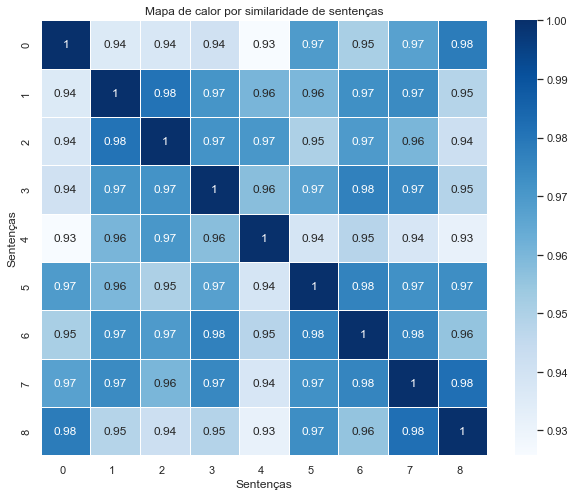

In [232]:
# Plotando o mapa de calor com nossos dados:
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_scores, annot=True, cmap="Blues", linewidths=0.5)
plt.xlabel("Sentenças")
plt.ylabel("Sentenças")
plt.title("Mapa de calor por similaridade de sentenças")
plt.xticks(ha="right")
plt.show()

In [233]:
################## OBS: EU NÃO SEI PQ ESTÁ TUDO TÃO ALTO

In [178]:
data.close()

E é isso!

# Conclusões

Neste projeto, pudemos explorar o poder da análise quantitativa e, principalmente, dos embeddings, compreendendo mais profundamente algumas tendências e nuances da obra de Clarice Lispector. Além disso, o uso dos embeddings trouxe à luz a complexidade do treinamento de modelos, levando-nos a refletir sobre a viabilidade de utilizar abordagens pré-treinadas, como BERTimbau e os Word Embeddings do NILC, para tarefas futuras - visto que ambos forram capazes de capturar o contexto das frases, prova tangível do potencial desses modelos.

Embora possamos dar este projeto como concluído, as possibilidades oferecidas pelo NLP e a análise de textos são muito mais vastas e abangentes, de forma que as lições aprendidas aqui serão fundamentais à medida que avançamos em direção a desafios mais complexos da compreensão automática da linguagem humana.

# Sites visitados:
- https://stackoverflow.com/questions/15547409/how-to-get-rid-of-punctuation-using-nltk-tokenizer
- https://www.youtube.com/watch?v=_HxrS1jiPAc&ab_channel=Zurubabel
- https://spacy.io/universe/project/video-spacys-ner-model-alt
- https://medium.com/turing-talks/word-embedding-fazendo-o-computador-entender-o-significado-das-palavras-92fe22745057
- https://towardsdatascience.com/understanding-word2vec-embedding-in-practice-3e9b8985953
- https://www.deeplearningbook.com.br/o-que-e-bert-bidirectional-encoder-representations-from-transformers/
- https://www.youtube.com/watch?v=Qo8AQwgNV70&ab_channel=ThiagoCastroFerreira
- https://www.youtube.com/watch?v=GncyWR-dYW8&ab_channel=ThiagoCastroFerreira
- https://huggingface.co/neuralmind/bert-base-portuguese-cased
- https://huggingface.co/rufimelo/Legal-BERTimbau-base
- https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/
- http://mccormickml.com/2019/07/22/BERT-fine-tuning/